In [6]:
import numpy as np
import pandas as pd
import random
import gym
from gym import spaces
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

class CryptoTrader(gym.Env):
    def __init__(self, data, capital):
        self.data = data
        self.capital = capital
        self.reward_range = (-np.inf, np.inf)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(data.columns),))

    def reset(self):
        self.current_step = 0
        self.balance = self.capital
        self.stocks = 0
        self.net_worth = self.balance + (self.stocks * self.data.iloc[self.current_step]['Close'])
        self.profit = 0
        return self.data.iloc[self.current_step]

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        done = False
        if action > 0: # покупка
            affordable_stocks = int(self.balance / current_price)
            stocks_bought = int(affordable_stocks * action)
            cost = stocks_bought * current_price
            self.balance -= cost
            self.stocks += stocks_bought
        elif action < 0: # продажа
            stocks_sold = int(self.stocks * abs(action))
            profit = stocks_sold * current_price
            self.balance += profit
            self.stocks -= stocks_sold
            self.profit += profit
        self.net_worth = self.balance + (self.stocks * current_price)
        self.current_step += 1
        if self.current_step >= len(self.data.index)-1:
            done = True
        obs = self.data.iloc[self.current_step]
        reward = self.net_worth - self.capital
        return obs, reward, done, {}

def build_model(input_shape):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=input_shape))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def train_model(env, episodes, steps):
    input_shape = env.observation_space.shape
    model = build_model(input_shape)
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, input_shape[0]])
        for step in range(steps):
            action = model.predict(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, input_shape[0]])
            target = reward
            if not done:
                target = (reward + 0.95 * np.amax(model.predict(next_state)[0]))
            target_f = model.predict(state)
            target_f[0] = target
            model.fit(state, target_f, epochs=1, verbose=0)
            state = next_state
            if done:
                break

        print("Episode ", episode + 1, " total net worth: ", env.net_worth)

    return model

if __name__ == '__main__':
    data = pd.read_csv('data.csv')
    capital = 1000
    env = CryptoTrader(data, capital)
    model = train_model(env, episodes=100, steps=200)

ModuleNotFoundError: No module named 'gym'

In [5]:
import numpy as np
import tensorflow as tf

# Гиперпараметры
learning_rate = 0.001
discount_factor = 0.99  # Фактор дисконтирования для будущих наград
input_shape = (10,)  # Примерный размер входных данных

# Создание нейронной сети
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # 2 выхода: 0 для продажи, 1 для покупки
])

# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Функция для принятия решения на основе выходов нейронной сети
def get_action(state):
    # Получаем вероятности покупки и продажи
    probabilities = model.predict(np.array([state]))[0]
    # Принимаем решение на основе вероятностей
    action = np.random.choice([0, 1], p=probabilities)
    return action

# Функция для обучения нейронной сети с подкреплением
def train_step(states, actions, rewards):
    with tf.GradientTape() as tape:
        # Предсказываем вероятности для выбранных действий
        probabilities = model(states)
        # Преобразуем действия в one-hot представление
        action_masks = tf.one_hot(actions, 2)
        selected_probabilities = tf.reduce_sum(probabilities * action_masks, axis=1)
        # Вычисляем потери с учетом фактора дисконтирования и награды
        loss = -tf.reduce_sum(tf.math.log(selected_probabilities) * rewards)

    # Обновляем веса модели
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Пример генерации данных и обучения
num_episodes = 1000
for episode in range(num_episodes):
    # Генерация случайных состояний и действий (замените на свои данные)
    states = np.random.random((100, 10))
    actions = np.random.randint(0, 2, size=100)
    rewards = np.random.random(100)  # Пример награды (замените на свои данные)

    # Обучение модели
    train_step(states, actions, rewards)

    # Пример принятия решения
    state = np.random.random(10)  # Пример текущего состояния (замените на свои данные)
    action = get_action(state)
    print("Episode:", episode, " Action:", action)


1/1 [==============================] - 0s 243ms/step
Episode: 0  Action: 1
1/1 [==============================] - 0s 30ms/step
Episode: 1  Action: 0
1/1 [==============================] - 0s 30ms/step
Episode: 2  Action: 0
1/1 [==============================] - 0s 29ms/step
Episode: 3  Action: 0
1/1 [==============================] - 0s 33ms/step
Episode: 4  Action: 0
1/1 [==============================] - 0s 26ms/step
Episode: 5  Action: 0
1/1 [==============================] - 0s 23ms/step
Episode: 6  Action: 1
1/1 [==============================] - 0s 25ms/step
Episode: 7  Action: 0
1/1 [==============================] - 0s 38ms/step
Episode: 8  Action: 0
1/1 [==============================] - 0s 22ms/step
Episode: 9  Action: 0
1/1 [==============================] - 0s 24ms/step
Episode: 10  Action: 1
1/1 [==============================] - 0s 32ms/step
Episode: 11  Action: 0
1/1 [==============================] - 0s 29ms/step
Episode: 12  Action: 0
1/1 [=============================

In [2]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

import numpy as np

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2

    A = np.mean(rets)
    B = np.mean(np.square(rets))
    S = A / np.sqrt(B - A ** 2)

    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta

    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta


    return grad, S

def train(x, epochs=500, M=5, commission=0.0025, learning_rate = 0.1):
    theta = np.ones(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe


    print("finished training")
    return theta, sharpes

In [15]:
import pandas as pd

data_lkoh = pd.read_parquet('data/data_lkoh.parquet')

data_lkoh_2 = data_lkoh.rename(columns={'Дата': 'utc', 'Цена': 'price', 'Объём': 'volume'})
btc = data_lkoh_2.set_index('utc')[['price','volume']]
btc.index = pd.to_datetime(btc.index, unit='s')
rets = btc['price'].diff()[1:]

x = np.array(rets)
x = (x - np.mean(x)) / np.std(x) # normalize

N = 2000
P = 600
x_train = x[-(N+P):-P]
x_test = x[-P:]

In [16]:
import matplotlib.pyplot as plt

In [88]:
theta, sharpes = train(x_train, epochs=50, M=100, commission=0.03, learning_rate=.01)

finished training


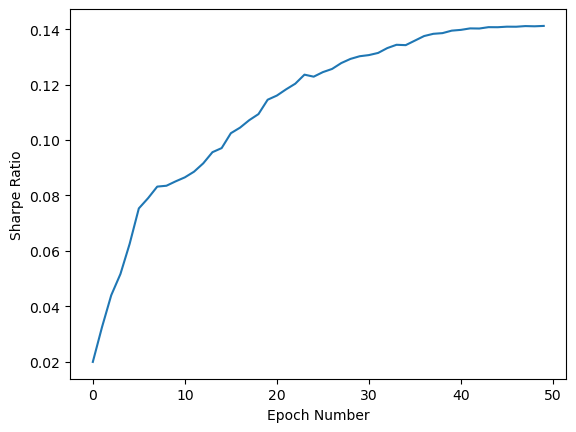

In [89]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

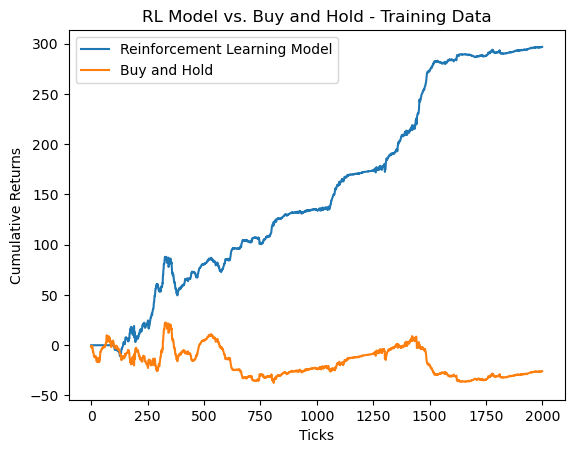

In [90]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_train.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

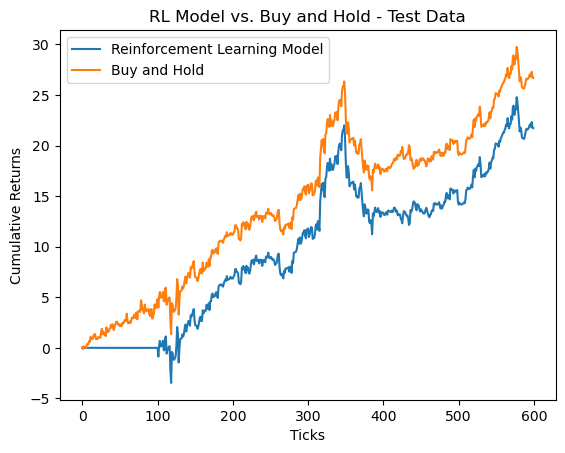

In [91]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_test.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");

In [87]:
test_returns_buy_hold = x_test.cumsum()[-1]  # Итоговая доходность Buy and Hold
test_returns_algo = test_returns.cumsum()[-1]  # Итоговая доходность вашего алгоритма
print(test_returns_buy_hold)
print(test_returns_algo)

26.689764220342095
21.30565303761197


In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
from sklearn.preprocessing import StandardScaler

# ... (existing code for sharpe_ratio, positions, returns, and gradient) ...

class DQLModel(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(DQLModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', input_shape=(state_size,))
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(action_size, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

class DQLAgent:
    def __init__(self, state_size, action_size, learning_rate, discount_factor, epsilon_decay):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.model = DQLModel(self.state_size, self.action_size)
        self.target_model = DQLModel(self.state_size, self.action_size)
        self.optimizer = tf.optimizers.Adam(self.learning_rate)
        self.memory = deque(maxlen=2000)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = np.array(random.sample(self.memory, batch_size))
        states = np.vstack(minibatch[:, 0])
        actions = minibatch[:, 1].astype(int)
        rewards = minibatch[:, 2]
        next_states = np.vstack(minibatch[:, 3])
        dones = minibatch[:, 4]

        target_values = self.target_model.predict(next_states)
        targets = rewards + self.discount_factor * np.max(target_values, axis=1) * (1 - dones)

        with tf.GradientTape() as tape:
            q_values = self.model(states)
            selected_action_values = tf.reduce_sum(q_values * tf.one_hot(actions, self.action_size), axis=1)
            loss = tf.reduce_mean(tf.square(targets - selected_action_values))
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ... (existing code for train, data_lkoh, etc.) ...

def train_dql(x_train, epochs=500, M=5, commission=0.0025, learning_rate=0.1):
    state_size = M + 2
    action_size = 3  # Sell, Hold, Buy
    agent = DQLAgent(state_size, action_size, learning_rate, discount_factor=0.99, epsilon_decay=0.995)

    # Preprocess and normalize the input data
    x_train = np.array(x_train).reshape(-1, 1)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train).flatten()

    # Initialize variables
    sharpes = np.zeros(epochs)

    for i in range(epochs):
        state = np.concatenate([x_train[i:i+M], [0] * 2])  # Initial state
        state = np.reshape(state, [1, state_size])

        done = False
        total_reward = 0
        j = M  # Starting index for x_train

        while not done:
            action = agent.choose_action(state)
            next_state = np.concatenate([x_train[j:j+M], [action] * 2])
            next_state = np.reshape(next_state, [1, state_size])
            reward = returns(np.array([action]), np.array([x_train[j]]), commission)[0]
            total_reward += reward
            done = (j == len(x_train) - 1)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            j += 1

            if done:
                print("Episode {}/{} - Total Reward: {:.2f}".format(i + 1, epochs, total_reward))
                break

            agent.experience_replay(batch_size=32)

        agent.update_target_model()
        sharpes[i] = total_reward

    print("Finished training")
    return agent.model, sharpes

# ... (remaining code for defining x_train and x_test, and plotting results) ...

# Train the DQL model
dql_model, dql_sharpes = train_dql(x_train, epochs=20, M=5, commission=0.0025, learning_rate=0.001)

# ... (rest of the code for plotting DQL model results) ...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (32, 5) + inhomogeneous part.

In [2]:

import numpy as np


In [9]:
epsilon_min = 0.1  # значение epsilon_min из кода
epsilon_decay = 0.999**8 # значение epsilon_decay из кода
epsilon = 0.5
epsilon *= epsilon_decay
x = round(np.log(epsilon_min /epsilon) / np.log(epsilon_decay))
x

200

In [109]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()
def create_model(input_shape, output_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model
def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2

    A = np.mean(rets)
    B = np.mean(np.square(rets))
    S = A / np.sqrt(B - A ** 2)

    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta


    return grad, S

def train(x, epochs=500, M=5, commission=0.0025, learning_rate=0.1):
    theta = np.ones(M + 2)
    sharpes = np.zeros(epochs)  # store sharpes over time

    # Create the deep Q-learning model
    input_shape = (M + 2,)
    output_shape = 1
    model = create_model(input_shape, output_shape)

    for i in range(epochs):
        # Get the current state
        state = positions(x, theta)

        # Choose an action using the deep Q-learning model
        action = np.argmax(model.predict(np.expand_dims(state, axis=0)))

        # Update the theta values based on the chosen action
        theta[action] += learning_rate

        # Calculate the gradient and Sharpe ratio
        grad, sharpe = gradient(x, theta, commission)

        # Update the deep Q-learning model using the gradient
        model.fit(np.expand_dims(state, axis=0), np.expand_dims(grad, axis=0), epochs=1, verbose=0)

        sharpes[i] = sharpe

    print("finished training")
    return theta, sharpes
data_lkoh = pd.read_parquet('data/data_lkoh.parquet')

data_lkoh_2 = data_lkoh.rename(columns={'Дата': 'utc', 'Цена': 'price', 'Объём': 'volume'})
btc = data_lkoh_2.set_index('utc')[['price','volume']]
btc.index = pd.to_datetime(btc.index, unit='s')
rets = btc['price'].diff()[1:]

x = np.array(rets)
x = (x - np.mean(x)) / np.std(x) # normalize

N = 2000
P = 600
x_train = x[-(N+P):-P]
x_test = x[-P:]

In [110]:
theta, sharpes = train(x_train, epochs=20, M=5, commission=0.0025, learning_rate=0.001)
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_test.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data")
plt.show()

ValueError: in user code:

    File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 7), found shape=(None, 2000)


In [35]:
from collections import deque
import random
import tensorflow as tf
import numpy as np


import random
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size, volume, day_of_week,dayofyear,EMA_20,MACD,Signal_Line):
        self.volume = volume
        self.day_of_week = day_of_week
        
        self.dayofyear = dayofyear
        self.EMA_20 = EMA_20
        self.MACD = MACD
        self.Signal_Line = Signal_Line
        
        
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen=batch_size)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(self.state_size,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.action_size)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error')
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(self.model.predict(state.reshape(1, self.state_size),verbose = 0)[0])
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        block_volume = self.volume[d : t] if d >= 0 else -d * [self.volume[0]] + self.volume[0 : t]  # adjusted slicing
        block_day_of_week = self.day_of_week[d : t] if d >= 0 else -d * [self.day_of_week[0]] + self.day_of_week[0 : t]  # adjusted slicing
        
        block_dayofyear = self.dayofyear[d : t] if d >= 0 else -d * [self.dayofyear[0]] + self.dayofyear[0 : t]  # adjusted slicing
        block_EMA_20 = self.EMA_20[d : t] if d >= 0 else -d * [self.EMA_20[0]] + self.EMA_20[0 : t]  # adjusted slicing
        block_MACD = self.MACD[d : t] if d >= 0 else -d * [self.MACD[0]] + self.MACD[0 : t]  # adjusted slicing
        block_Signal_Line= self.Signal_Line[d : t] if d >= 0 else -d * [self.Signal_Line[0]] + self.Signal_Line[0 : t]  # adjusted slicing
        
        res = np.concatenate((np.diff(block), block_volume, block_day_of_week,block_dayofyear,block_EMA_20,block_MACD,block_Signal_Line), axis=None)
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = random.sample(self.memory, batch_size)
        states = np.array([state for state, _, _, _, _ in mini_batch])
        actions = np.array([action for _, action, _, _, _ in mini_batch])
        rewards = np.array([reward for _, _, reward, _, _ in mini_batch])
        next_states = np.array([next_state for _, _, _, next_state, _ in mini_batch])
        dones = np.array([done for _, _, _, _, done in mini_batch])

        targets = self.model.predict(states)
        next_state_targets = self.model.predict(next_states)
        max_next_state_targets = np.max(next_state_targets, axis=1)

        targets[np.arange(batch_size), actions] = rewards + self.gamma * max_next_state_targets * (1 - dones)

        self.model.fit(states, targets, batch_size=batch_size, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f' % (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f,' %
                      (t, close[t], invest, initial_money))

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))
                state = next_state
                if len(self.memory) > self.batch_size:
                    self.replay(self.batch_size)
            if (i + 1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, total money: %f' % (i + 1, total_profit, starting_money))


In [20]:
import pandas as pd
import random


data_lkoh = pd.read_parquet('data/data_lkoh.parquet')

In [ ]:
head = 400
split = 0.5
initial_money = 10000
window_size = 30
skip = 4
batch_size = 16
df = data_lkoh.copy()
data_100 = df.head(head)

name = 'Q-learning agent'
data_100 = data_100.sort_index(ascending=False)
data_100 = data_100.reset_index(drop=True)
# Assuming df is your DataFrame and 'Цена' is your target column
data = data_100['Цена'].values.tolist()
volume = data_100.Объём.values.tolist()
day_of_week = data_100.dayofweek.values.tolist()  # assuming you have a column named 'DayOfWeek'

dayofyear = data_100.dayofyear.values.tolist()  # assuming you have a column named 'dayofyear'
EMA_20 = data_100.EMA_20.values.tolist()  # assuming you have a column named 'DayOfWeek'
MACD = data_100.MACD.values.tolist()  # assuming you have a column named 'DayOfWeek'
Signal_Line = data_100.Signal_Line.values.tolist()  # assuming you have a column named 'DayOfWeek'
# Define the size of the training set. For example, 80% for training, 20% for testing.
train_size = int(len(data) * split)

# Split the data
train_data = data[:train_size]
test_data = data[train_size:]
# Train the agent with the training data
close = data_100.Цена.values.tolist()[:train_size]

agent = Agent(state_size = window_size * 7,  # updated state_size
              window_size = window_size,
              trend = train_data,
              skip = skip,
              batch_size = batch_size,
              volume = volume[:train_size],
              day_of_week = day_of_week[:train_size],
              dayofyear = dayofyear[:train_size],
              EMA_20 = EMA_20[:train_size],
              MACD = MACD[:train_size],
              Signal_Line = Signal_Line[:train_size],
              )

agent.train(iterations = 200, checkpoint = 5, initial_money = initial_money)

32 32 SGD
epoch: 5, total rewards: 482.000000.3, total money: 6220.000000
epoch: 10, total rewards: 464.000000.3, total money: 4680.000000
epoch: 15, total rewards: 120.000000.3, total money: 8578.000000
epoch: 20, total rewards: 72.000000.3, total money: 5618.000000
epoch: 25, total rewards: -227.000000.3, total money: 5444.000000
epoch: 30, total rewards: -138.000000.3, total money: 3858.000000
epoch: 35, total rewards: -467.000000.3, total money: 6502.000000
epoch: 40, total rewards: -163.000000.3, total money: 4216.000000
epoch: 45, total rewards: -551.000000.3, total money: 9449.000000
epoch: 50, total rewards: 830.000000.3, total money: 6505.000000
epoch: 55, total rewards: 220.000000.3, total money: 1483.000000
epoch: 60, total rewards: 257.000000.3, total money: 8729.000000
epoch: 65, total rewards: 498.000000.3, total money: 1593.000000
epoch: 70, total rewards: -145.000000.3, total money: 8327.000000
epoch: 75, total rewards: -138.000000.3, total money: 9862.000000

32 SGD
epoch: 5, total rewards: -51.000000.3, total money: 269.000000
epoch: 10, total rewards: 361.000000.3, total money: 3660.000000
epoch: 15, total rewards: 505.000000.3, total money: 904.000000
epoch: 20, total rewards: 486.000000.3, total money: 2355.000000
epoch: 25, total rewards: 279.000000.3, total money: 2050.000000
epoch: 30, total rewards: 388.000000.3, total money: 4826.000000
epoch: 35, total rewards: 484.000000.3, total money: 3735.000000
epoch: 40, total rewards: 1123.000000.3, total money: 5522.000000
epoch: 45, total rewards: -321.000000.3, total money: 470.000000
epoch: 50, total rewards: 296.000000.3, total money: 3263.000000
epoch: 55, total rewards: -80.000000.3, total money: 2132.000000
epoch: 60, total rewards: 28.000000.3, total money: 1559.000000
epoch: 65, total rewards: -947.000000.3, total money: 552.000000
epoch: 70, total rewards: 361.000000.3, total money: 825.000000
epoch: 75, total rewards: 394.000000.3, total money: 1858.000000

256 SGD
epoch: 5, total rewards: -646.000000.3, total money: 9354.000000
epoch: 10, total rewards: 323.000000.3, total money: 10323.000000
epoch: 15, total rewards: -197.000000.3, total money: 9803.000000
epoch: 20, total rewards: 461.000000.3, total money: 10461.000000
epoch: 25, total rewards: 370.000000.3, total money: 8948.000000
epoch: 30, total rewards: -7.000000.3, total money: 9993.000000
epoch: 35, total rewards: 334.000000.3, total money: 10334.000000
epoch: 40, total rewards: 213.000000.3, total money: 8782.000000
epoch: 45, total rewards: 402.000000.3, total money: 10402.000000
epoch: 50, total rewards: -770.000000.3, total money: 9230.000000
epoch: 55, total rewards: 7.000000.3, total money: 10007.000000
epoch: 60, total rewards: 28.000000.3, total money: 10028.000000
epoch: 65, total rewards: -47.000000.3, total money: 9953.000000
epoch: 70, total rewards: -353.000000.3, total money: 9647.000000
epoch: 75, total rewards: 479.000000.3, total money: 10479.000000

In [25]:
states_buy_train, states_sell_train, total_gains_train, invest_train = agent.buy(initial_money = initial_money)
# Update the trend, volume, day_of_week, dayofyear, EMA_20, MACD, and Signal_Line of the agent with the test data
agent.trend = test_data
agent.volume = volume[train_size:]
agent.day_of_week = day_of_week[train_size:]
agent.dayofyear = dayofyear[train_size:]
agent.EMA_20 = EMA_20[train_size:]
agent.MACD = MACD[train_size:]
agent.Signal_Line = Signal_Line[train_size:]


close = data_100.Цена.values.tolist()[train_size:]

states_buy_test, states_sell_test, total_gains_test, invest_test = agent.buy(initial_money = initial_money)

1/1 [==============================] - 0s 25ms/step
day 2: buy 1 unit at price 1703.000000, total balance 8297.000000
day 4, sell 1 unit at price 1616.000000, investment -5.108632 %, total balance 9913.000000,
1/1 [==============================] - 0s 23ms/step
day 10: buy 1 unit at price 1448.000000, total balance 8465.000000
1/1 [==============================] - 0s 24ms/step
day 12, sell 1 unit at price 1460.000000, investment 0.828729 %, total balance 9925.000000,
day 14: buy 1 unit at price 1351.000000, total balance 8574.000000
1/1 [==============================] - 0s 24ms/step
day 18: buy 1 unit at price 1257.000000, total balance 7317.000000
day 20: buy 1 unit at price 1203.000000, total balance 6114.000000
day 22: buy 1 unit at price 1242.000000, total balance 4872.000000
1/1 [==============================] - 0s 24ms/step
day 26, sell 1 unit at price 1153.000000, investment -14.655811 %, total balance 6025.000000,
day 30: buy 1 unit at price 1131.000000, total balance 4894.0

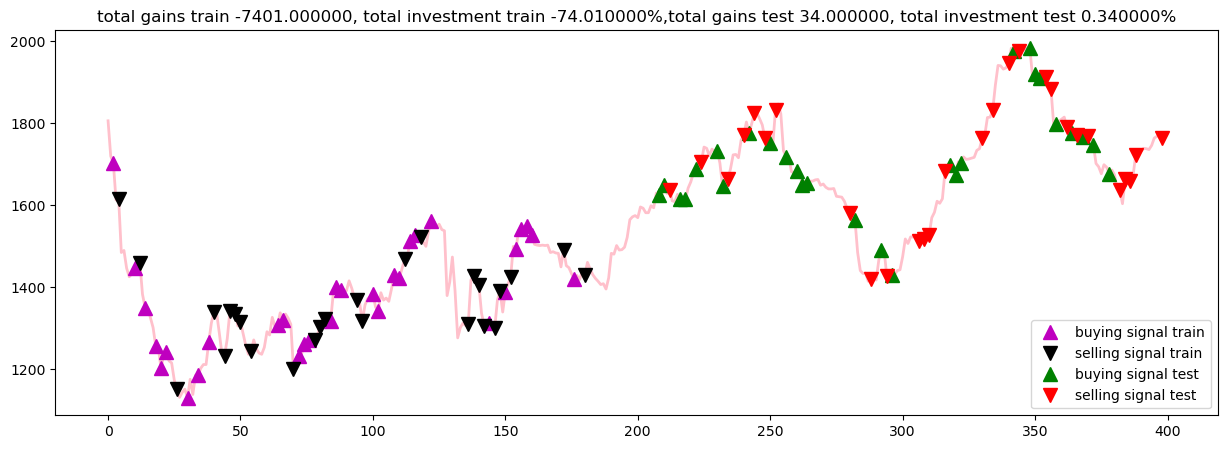

In [26]:

import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,5))
plt.plot(data, color='pink', lw=2.)
plt.plot(data, '^', markersize=10, color='m', label = 'buying signal train', markevery = states_buy_train)
plt.plot(data, 'v', markersize=10, color='k', label = 'selling signal train', markevery = states_sell_train)
states_buy_test_scaled = [x + int(head*split) for x in states_buy_test]
states_sell_test_scaled = [x + int(head*split) for x in states_sell_test]

plt.plot(data, '^', markersize=10, color='green', label = 'buying signal test', markevery = states_buy_test_scaled)
plt.plot(data, 'v', markersize=10, color='red', label = 'selling signal test', markevery = states_sell_test_scaled)


plt.title('total gains train %f, total investment train %f%%,total gains test %f, total investment test %f%%'%(total_gains_train, invest_train,total_gains_test, invest_test))
plt.legend()
plt.show()

In [ ]:
-0.56 and 2.7